In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from joblib import Parallel

from useful_func import *


from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from scipy.ndimage import binary_erosion


import tifffile as tiff
from tqdm import tqdm

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

import click

#%matplotlib widget

In [3]:
file= "../data/epi_shape/video_gel_full.tiff"
timing = np.load("../data/epi_shape/video_timing_gel_full.npy")

name = os.path.split(file)[1][:-5]
#file = click.prompt("Enter the file or folder path", type=str, default=file_default)

if os.path.isfile(file):
    video = tiff.imread(file)
    
elif os.path.isdir(file):
    video = []
    for im in tqdm(glob.glob(file + "/*.tiff")):
        video.append(tiff.imread(im))
    video = np.array(video)
    
else:
    print('wrong path')
    
    


In [4]:
framerate = len(timing)/(timing[-1]-timing[0])
framerate

3.045287073132167

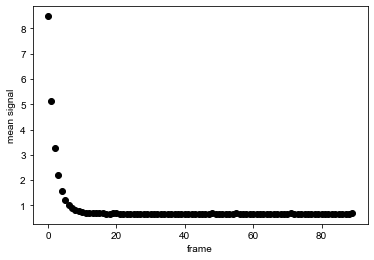

<Figure size 432x288 with 0 Axes>

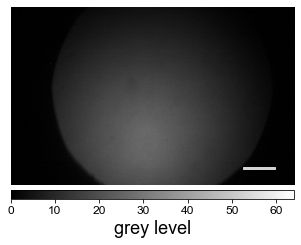

In [5]:
plt.xlabel('frame')
plt.ylabel('mean signal')
plt.plot(np.mean(video[0:], axis = (1,2)), "ko")
plt.figure()

slices = np.mean(video, axis = (1,2))
frames = video[0:1]
frame_ref = np.mean(frames, axis =0)


p.set_figure()
plt.axis("off")
image = plt.imshow(video[0][::-1], cmap = "gray")
L, H = video[0].shape
scale = 660//6
rec = matplotlib.patches.Rectangle((H-H//5.5, L-L//10), scale, L//100, color = "lightgrey")
#rec = matplotlib.patches.Rectangle((H, L), scale*10, L, color = "red")

ax = plt.gca()
ax.add_patch(rec)
divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel("grey level", size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)


plt.savefig(p.save_folder + "/epi_intensity" + p.extension)

plt.savefig("../images/"+ name + "_image.pdf")

In [6]:
L//6

101

In [7]:
D = click.prompt("smoothing & downscaling factor to accelerate computations", type=int, default=5)
D_image = downscale_local_mean(frame_ref, (D,D))

#downscaling 
video_downscaled = []
for i in range(0, video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]


smoothing & downscaling factor to accelerate computations [5]:

  1


skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


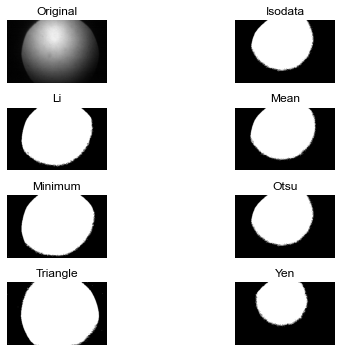

In [37]:
u = skimage.filters.try_all_threshold(D_image)


copy the name of the thresholding method that suits you. If none suits, enter None [skimage.filters.thresholding.threshold_li]:

  None


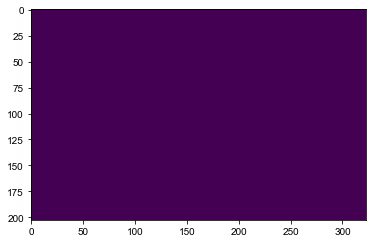

In [38]:
threshold_method = threshold_convert(click.prompt("copy the name of the thresholding method that suits you. If none suits, enter None", type = str, default="skimage.filters.thresholding.threshold_li"))

video = np.array(video)
#timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
timing -= timing[0]
threshold = threshold_method(D_image)

mask = D_image>=0#threshold/4

plt.imshow(mask)



Text(0, 0.5, 'fluorescence')

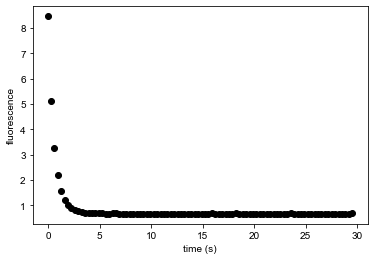

In [39]:
video_2D = np.copy(video_downscaled)
video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

to_evaluate = video_downscaled[:,mask.flatten()]

plt.plot(timing, np.mean(to_evaluate, axis = 1), 'ok')
plt.xlabel('time (s)')
plt.ylabel('fluorescence')

First useful frame [0]:

  0


Last useful frame [0]:

  100


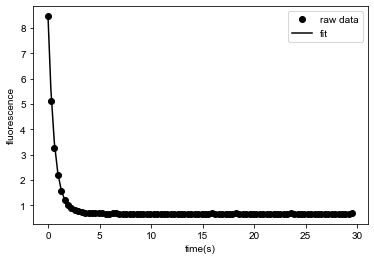

In [40]:
start = click.prompt("First useful frame", type=int, default=0)
stop = click.prompt("Last useful frame", type=int, default=0)


#fit on the mean value before performing the fit on each pixel
params = simple_tau(np.mean(to_evaluate[start:stop], axis = 1), timing[start:stop], sample_rate = framerate)

time = timing[start:stop]
time -= time[0]
plt.plot(time, np.mean(to_evaluate[start:stop], axis = 1), "ok", label = "raw data")
plt.plot(time, exp_decay(params, time), "k", label = "fit")
plt.xlabel('time(s)')
plt.ylabel("fluorescence")
plt.legend()
plt.savefig(p.save_folder + name +  "_mean_decay_fit_D2.png")

In [41]:
sat = np.sum(to_evaluate[0]==255)/len(to_evaluate[0].flatten())*100
print("percent of saturated pixels in the mask: ", sat)
if sat > 2:
    print("WARNING, more than 2% of the pixels are saturated on the first frame, try acquiring the movie with shorter exposure/smaller gain.")

percent of saturated pixels in the mask:  0.0


In [42]:
#parallel fit on each pixel of the mask
tau_lists = Parallel(n_jobs = -1 )(parallel_tau(to_evaluate[start:stop,i], timing[start:stop], sample_rate = framerate) for i in tqdm(range(to_evaluate.shape[1])))


100%|██████████████████████████████████████████████████████████████████████████| 65569/65569 [01:04<00:00, 1020.90it/s]


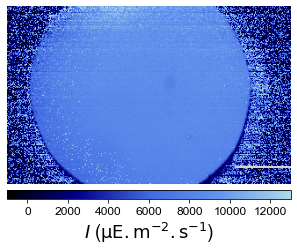

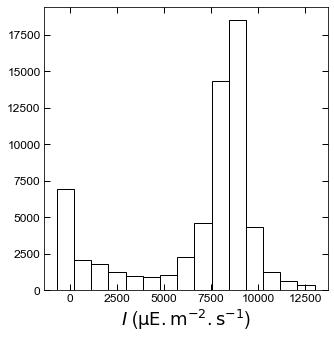

In [46]:
tau_480 = np.array(tau_lists)
tau_480_map = np.zeros(mask.shape)
tau_480_map[mask] = tau_480

np.save("../images/tau_480_map_gel_fort.npy", tau_480_map)


I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480

np.save("../images/I_480_map_gel_fort.npy", I_480_map)

plt.rcParams['image.cmap'] = 'viridis'

p.extension = ".pdf"
 
I, dis, fig = plot_map(I_480, I_480_map[::-1, ::-1], name + "_I_480_map_B" + p.extension, limits = (-1000, 13000))



np.save("../images/video_2D_gel_fort.npy", video_2D[start:stop])
np.save("../images/framerate_gel_fort.npy", framerate)


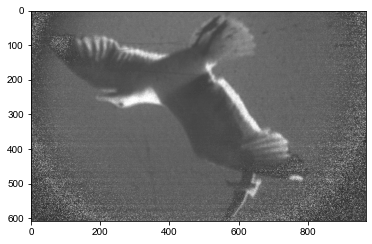

In [78]:
plt.imshow(I_480_map, cmap = 'gray')

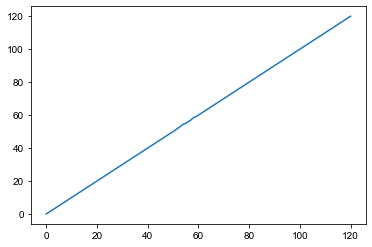

In [22]:
plt.plot(timing)

3.033560379602061
(180, 608, 968)
tau 0.9116697519906193
3.02592364259727
(180, 608, 968)
tau 1.0260770660401557


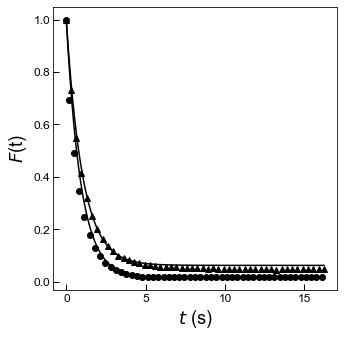

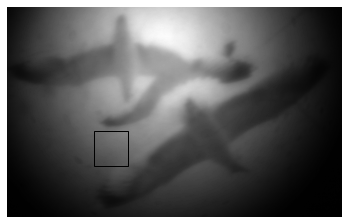

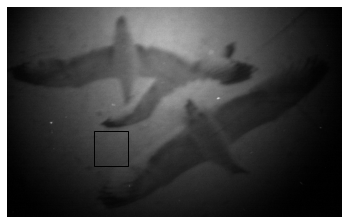

In [24]:
f0 = p.set_figure("%d", "%0.1f")
ax0 = plt.gca()
p.extension = ".pdf"
plt.xlabel('$t$ (s)')
plt.ylabel("$F$(t)")

for num, fname in enumerate(["liq_light", "gel_light2"]): #["mouette_liq_fort", "mouette_gel_fort"]): #

    file= "../data/epi_shape/video_%s.tiff"%fname
    timing = np.load("../data/epi_shape/video_timing_%s.npy"%fname)

    framerate = len(timing)/(timing[-1]-timing[0])
    print(framerate)

    name = os.path.split(file)[1][:-5]
    #file = click.prompt("Enter the file or folder path", type=str, default=file_default)

    if os.path.isfile(file):
        video = tiff.imread(file)

    elif os.path.isdir(file):
        video = []
        for im in tqdm(glob.glob(file + "/*.tiff")):
            video.append(tiff.imread(im))
        video = np.array(video)

    else:
        print('wrong path')

    D=1

    print(video.shape)
    slices = np.mean(video, axis = (1,2))
    frames = video[:1]
    frame_ref = np.mean(frames, axis =0)
    D = 1#click.prompt("smoothing & downscaling factor to accelerate computations", type=int, default=5)
    D_image = downscale_local_mean(frame_ref, (D,D))

    f1 = plt.figure()


    plt.imshow(frame_ref, cmap = 'gray')
    plt.axis("off")
    a, b, c, d = 250, 360, 100, 100
    rec = matplotlib.patches.Rectangle((a, b), c, d, color = "k", fill = False)
    #rec = matplotlib.patches.Rectangle((H, L), scale*10, L, color = "red")

    ax = plt.gca()
    ax.add_patch(rec)
    plt.savefig(p.save_folder + "_area_intergrate_%d.pdf"%num)
    
    #downscaling 
    video_downscaled = []
    for i in range(0, video.shape[0]):
        video_downscaled.append(downscale_local_mean(video[i], (D, D)))
    video_downscaled = np.array(video_downscaled)
    init_shape = np.copy(video_downscaled.shape)
    L, H = init_shape[1:]


    video = np.array(video)
    #timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
    timing -= timing[0]

    mask = np.zeros(video[0].shape).astype(bool)
    mask[b:b+d, a:a+c] = 1

    #plt.figure()
    #plt.imshow(mask)

    video_2D = np.copy(video_downscaled)
    video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

    to_evaluate = video_downscaled[:,mask.flatten()]

    start = 0
    stop = 50


    time = timing[start:stop]
    time -= time[0]

    y = np.mean(to_evaluate[start:stop], axis = 1)
    y /= y[0]
                
    #fit on the mean value before performing the fit on each pixel
    params = simple_tau(y, time, sample_rate = framerate)
    print("tau", params[1])
    ax0.plot(time, y, ["ok", "^k"][num], label = "raw data")
    x2 = np.linspace(time.min(), time.max(), 1024)
    ax0.plot(x2, exp_decay(params, x2), "k", label = "fit")


    #plt.legend()
f0.savefig(p.save_folder + name +  "_mean_decay_fit_D2_area.pdf")


In [48]:
0.71-0.52

0.18999999999999995

In [23]:
p.save_folder + "_area_intergrate_%d.pdf"%num

'../images/_area_intergrate_1'